# Electrisity Output and Wind Speed Model 

## Regression Model

## Data exploration


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Columns: 114 entries, DATETIME to WS_921049
dtypes: datetime64[ns](1), float64(113)
memory usage: 83.0 KB
None


<AxesSubplot:xlabel='DATETIME'>

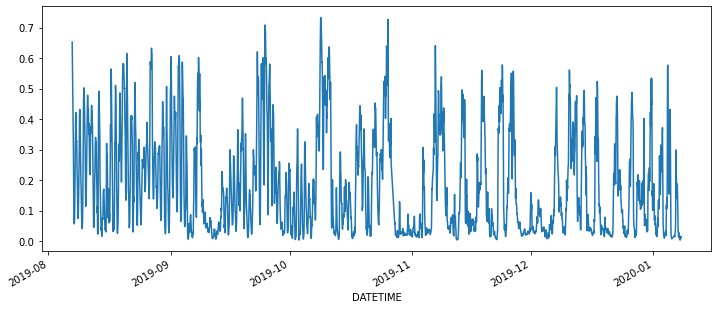

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data Analysis
df = pd.read_excel('data/Wind_data.xlsx', sheet_name=[0, 1])
df_train, df_test = df.get(0), df.get(1)

print(df_test.info())
# print(df_test.head())
# print(df_test.describe())
# print(df_train.isnull().values.any())
# print(df_test.isnull().any(axis=1).sum())
# print(df_test.isnull().any(axis=0).sum())
#df_train = df_train.dropna()
# dfp = pd.read_excel('data/Wind_data.xlsx', index_col='DATETIME', sheet_name=[0, 1])
# dfp.get(0)['CF'].plot(figsize=(12,5))

## Feature Engineering: Identify significant variables

<AxesSubplot:>

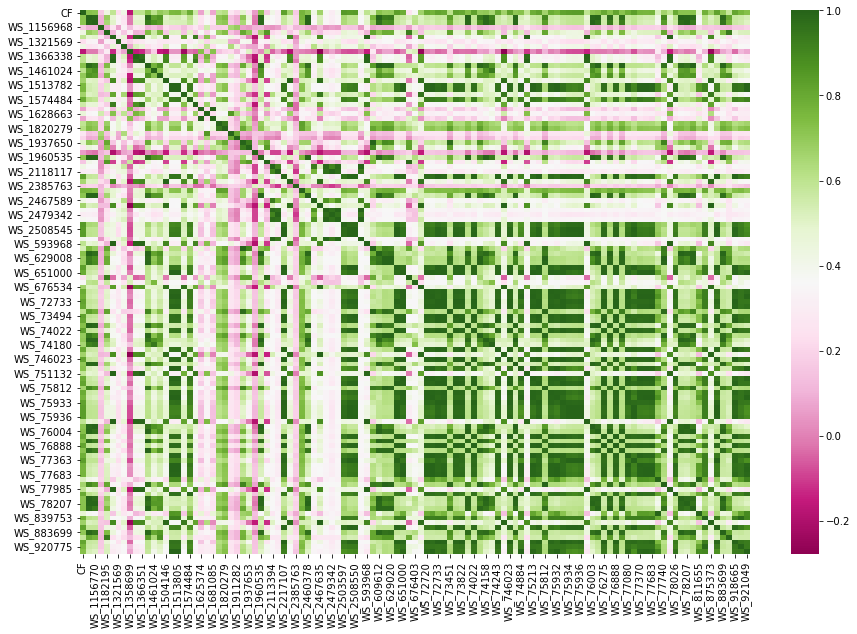

In [27]:
# Compute correlation between variables and target
# In this correlation map, light color means lower covariance of two variables.
# We can not manually decide which features are salent, it looks like most of the features are relavant. 
# As a result, some numeriacal feature selection algorithms can be adopted.

import seaborn as sns
data = df_train
data.corr(method='pearson')
plt.subplots(figsize=(15, 10))
sns.heatmap(data.corr(), cmap="PiYG")

### Naive Linear Regression Model without Feature Engineering

Training accu: 0.8938531689027774
Test accu: 0.8305763985836878
validation data MAE: 0.046
validation data MAE from sklearn mae metrics: 0.046


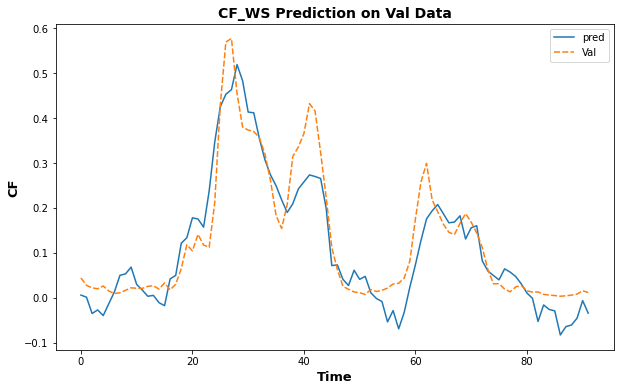

In [28]:
# shuffle data samples
# df_train = df_train.sample(frac = 1)

# extract hour, day, month feature
df_train['hour'] = df_train['DATETIME'].dt.hour
df_train['month'] = df_train['DATETIME'].dt.month
df_train['day'] = df_train['DATETIME'].dt.day

# split dataset
Y = df_train[['CF']]
# X = df_train.set_index('DATETIME')
X = df_train.drop(['DATETIME','CF'], axis=1)
# X = df_train.drop(['CF'], axis=1)
x_train, x_val,y_train, y_val = X[:-92], X[-92:], Y[:-92], Y[-92:]
x, y, x_val,y_val = x_train.values, y_train.values, x_val.values, y_val.values


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

mlr = LinearRegression()
sc_x = StandardScaler()

# scale and normalize training data
X_new = sc_x.fit_transform(x)

# model fitting
mlr.fit(X_new, y)

# prediction
X_val_new = sc_x.transform(x_val)
y_hat = mlr.predict(X_val_new)
print(f'Training accu: {mlr.score(X_new, y)}')
print(f'Test accu: {mlr.score(X_val_new, y_val)}')
mae = mean_absolute_error(y_val, y_hat)

#visualize predication 
results = np.concatenate((y_hat, y_val), axis=1)
df_res = pd.DataFrame(results, columns=["pred", "Val"])           
## Set figure size
fig, ax = plt.subplots(figsize = (10,6))
# Plot the curve
sns.lineplot(data=df_res)
ax.set_title('CF_WS Prediction on Val Data', fontdict={'fontsize':14, 'fontweight':'bold'})
# Set label for x-axis
ax.set_xlabel( "Time" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})
# Set label for y-axis
ax.set_ylabel( "CF" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})

# output MAE
print(f'validation data MAE: {np.mean(abs(y_hat - y_val)):.3f}')
print(f'validation data MAE from sklearn mae metrics: {mae:.3f}')

### Naive Linear Regression Model without Feature Engineering(shuffle train and val data)

#### data shuffle improved the result by 0.002 for linear regression

Training accu: 0.8929721489784179
Test accu: 0.9069282145816913
validation data MAE: 0.038
validation data MAE from sklearn mae metrics: 0.038


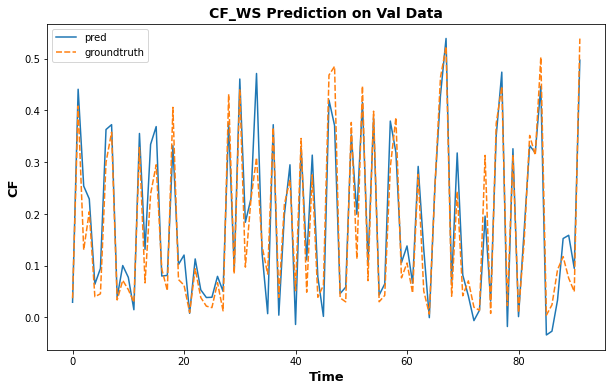

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

# shuffle data samples
df_train = df_train.sample(frac = 1)

# split dataset
Y = df_train[['CF']]
X = df_train.drop(['DATETIME','CF'], axis=1)

x_train, x_val,y_train, y_val = X[:-92], X[-92:], Y[:-92], Y[-92:]
x, y, x_val,y_val = x_train.values, y_train.values, x_val.values, y_val.values


mlr = LinearRegression()
sc_x = StandardScaler()

# scale and normalize training data
X_new = sc_x.fit_transform(x)

# model fitting
mlr.fit(X_new, y)

# prediction
X_val_new = sc_x.transform(x_val)
y_hat = mlr.predict(X_val_new)
print(f'Training accu: {mlr.score(X_new, y)}')
print(f'Test accu: {mlr.score(X_val_new, y_val)}')
mae = mean_absolute_error(y_val, y_hat)

#visualize predication 
results = np.concatenate((y_hat, y_val), axis=1)
df_res = pd.DataFrame(results, columns=["pred", "groundtruth"])           
## Set figure size
fig, ax = plt.subplots(figsize = (10,6))
# Plot the curve
sns.lineplot(data=df_res)
ax.set_title('CF_WS Prediction on Val Data', fontdict={'fontsize':14, 'fontweight':'bold'})
# Set label for x-axis
ax.set_xlabel( "Time" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})
# Set label for y-axis
ax.set_ylabel( "CF" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})

# output MAE
print(f'validation data MAE: {np.mean(abs(y_hat - y_val)):.3f}')
print(f'validation data MAE from sklearn mae metrics: {mae:.3f}')

### Engineer new features to improve the results
#### The above linear regression method sometimes is so simple that it can not fit complex functions. Hence I introducced PolynomialFeatures to project data into high dimension space to better fit the curve.

#### Naively adopting PolynomialFeatures leads to overfitting since 1) there's too many features here(115), it's very easy to get overfitting. 2) Polynomial Features in high dimensional space might also lead to overfitting. Hence I introducce L2 and L1 norm to supress overfitting.

Training accu: 1.0
Test accu: 0.7089026739447737
validation data MAE: 0.061
validation data MAE from sklearn mae metrics: 0.061


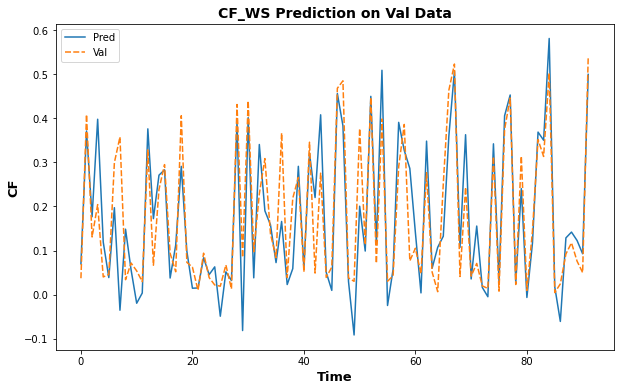

In [32]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# model define
mlr = LinearRegression()
sc_x = StandardScaler()



steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LinearRegression())
]

pipeline = Pipeline(steps)
pipeline.fit(x, y)
print(f'Training accu: {pipeline.score(x, y)}')
print(f'Test accu: {pipeline.score(x_val, y_val)}')

# prediction

y_hat = pipeline.predict(x_val)

mae = mean_absolute_error(y_val, y_hat)

#visualize predication 
results = np.concatenate((y_hat, y_val), axis=1)
df_res = pd.DataFrame(results, columns=["Pred", "Val"])           
## Set figure size
fig, ax = plt.subplots(figsize = (10,6))
# Plot the curve
sns.lineplot(data=df_res)
ax.set_title('CF_WS Prediction on Val Data', fontdict={'fontsize':14, 'fontweight':'bold'})
# Set label for x-axis
ax.set_xlabel( "Time" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})
# Set label for y-axis
ax.set_ylabel( "CF" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})

# output MAE
print(f'validation data MAE: {np.mean(abs(y_hat - y_val)):.3f}')
print(f'validation data MAE from sklearn mae metrics: {mae:.3f}')

### As a result, I introduced L1/L2 regularization to supress overfiting and further boost the results.

#### PolynomialFeatures + L2 regularization improved the results by a large margin(around 0.02)

Training accu: 0.9783262079769144
Test accu: 0.9477112196839356
validation data MAE: 0.027
validation data MAE from sklearn mae metrics: 0.027


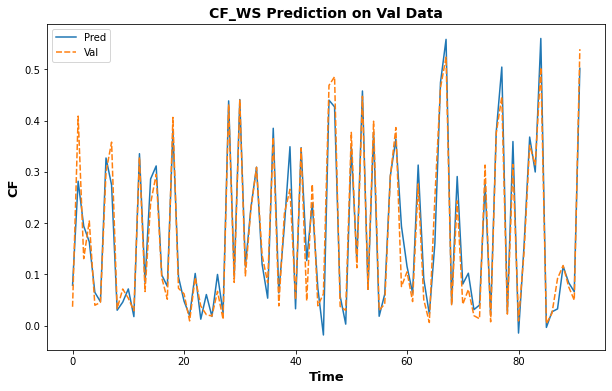

In [33]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

##  model define
# linear regression with L2 norm
# note that degree=3 for PolynomialFeatures provides even better results(increased by 0.005) but it takes much longer time to run.

steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Ridge(alpha=10, fit_intercept=True))
]

pipeline = Pipeline(steps)
pipeline.fit(x, y)
print(f'Training accu: {pipeline.score(x, y)}')
print(f'Test accu: {pipeline.score(x_val, y_val)}')

# prediction

y_hat = pipeline.predict(x_val)

mae = mean_absolute_error(y_val, y_hat)

#visualize predication 
results = np.concatenate((y_hat, y_val), axis=1)
df_res = pd.DataFrame(results, columns=["Pred", "Val"])           
## Set figure size
fig, ax = plt.subplots(figsize = (10,6))
# Plot the curve
sns.lineplot(data=df_res)
ax.set_title('CF_WS Prediction on Val Data', fontdict={'fontsize':14, 'fontweight':'bold'})
# Set label for x-axis
ax.set_xlabel( "Time" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})
# Set label for y-axis
ax.set_ylabel( "CF" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})

# output MAE
print(f'validation data MAE: {np.mean(abs(y_hat - y_val)):.3f}')
print(f'validation data MAE from sklearn mae metrics: {mae:.3f}')

#### PolynomialFeatures + L1 Regularization

/Users/steven/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.742e-01, tolerance: 9.672e-03
  model = cd_fast.enet_coordinate_descent(


Training accu: 0.9788358025619939
Test accu: 0.9463061158053642
(92, 1)
(92, 1)
validation data MAE: 0.027
validation data MAE from sklearn mae metrics: 0.027


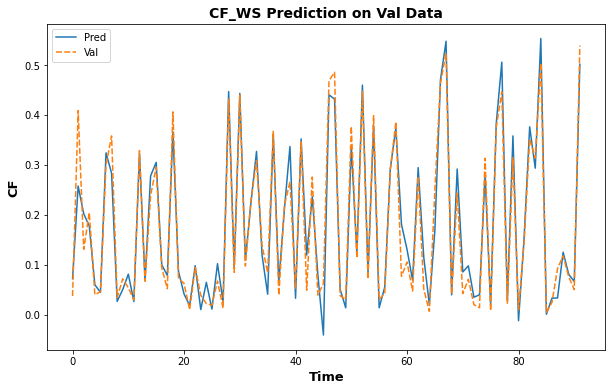

In [34]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Lasso(alpha=0.00001,fit_intercept=True))
]

laso_pipeline = Pipeline(steps)
laso_pipeline.fit(x, y)
print(f'Training accu: {laso_pipeline.score(x, y)}')
print(f'Test accu: {laso_pipeline.score(x_val, y_val)}')

# prediction

y_hat = laso_pipeline.predict(x_val)
mae = mean_absolute_error(y_val, y_hat)

#visualize predication 
y_hat = y_hat.reshape(y_hat.shape[0],-1)
print(y_hat.shape)
print(y_val.shape)
results = np.concatenate((y_hat, y_val), axis=1)
df_res = pd.DataFrame(results, columns=["Pred", "Val"])                 
## Set figure size
fig, ax = plt.subplots(figsize = (10,6))
# Plot the curve
sns.lineplot(data=df_res)
ax.set_title('CF_WS Prediction on Val Data', fontdict={'fontsize':14, 'fontweight':'bold'})
# Set label for x-axis
ax.set_xlabel( "Time" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})
# Set label for y-axis
ax.set_ylabel( "CF" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})

# output MAE
print(f'validation data MAE: {np.mean(abs(y_hat - y_val)):.3f}')
print(f'validation data MAE from sklearn mae metrics: {mae:.3f}')

#### Random Forest Regressor is the ensemble of a number of trees(weak classifier)
#### The result is comparable to Naive Linear Regression but not better than L2/L1 regualrization

Training accu: 0.8929721489784179
Test accu: 0.9069282145816913
validation data MAE: 0.038
validation data MAE from sklearn mae metrics: 0.038


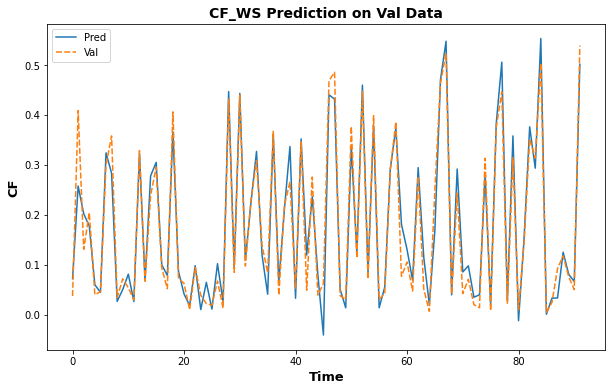

In [35]:
from sklearn import datasets, ensemble

from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


## gradientBoostingRegressor

params = {
    "max_depth": 4,
    "random_state": 0,
    
}

mlrf = ensemble.RandomForestRegressor(**params)
## engineer new features to improve the results

sc_x = StandardScaler()

# scale and normalize training data
X_new = sc_x.fit_transform(x)

# model fitting
mlr.fit(X_new, y)

# prediction
X_val_new = sc_x.transform(x_val)
y_hat = mlr.predict(X_val_new)
y_hat = y_hat.reshape(y_hat.shape[0],-1)
print(f'Training accu: {mlr.score(X_new, y)}')
print(f'Test accu: {mlr.score(X_val_new, y_val)}')
mae = mean_absolute_error(y_val, y_hat)

#visualize predication 
results = np.concatenate((y_hat, y_val), axis=1)
## Set figure size
fig, ax = plt.subplots(figsize = (10,6))
# Plot the curve
sns.lineplot(data=df_res)
ax.set_title('CF_WS Prediction on Val Data', fontdict={'fontsize':14, 'fontweight':'bold'})
# Set label for x-axis
ax.set_xlabel( "Time" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})
# Set label for y-axis
ax.set_ylabel( "CF" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})

# output MAE
print(f'validation data MAE: {np.mean(abs(y_hat - y_val)):.3f}')
print(f'validation data MAE from sklearn mae metrics: {mae:.3f}')

# steps = [
#     ('scalar', StandardScaler()),
#     ('poly', PolynomialFeatures(degree=2)),
#     ('model', ensemble.RandomForestRegressor(**params))
# ]

# rf_pipeline = Pipeline(steps)
# y = y.reshape(y.shape[0])
# rf_pipeline.fit(x, y)
# print(f'Train : {rf_pipeline.score(x, y)}')
# print(f'Val: {rf_pipeline.score(x_val, y_val)}')

# # prediction

# y_hat = rf_pipeline.predict(x_val)
# mae = mean_absolute_error(y_val, y_hat)

# #visualize predication 
# fig, ax = plt.subplots()
# y_hat = y_hat.reshape(y_hat.shape[0],-1)
# print(y_hat.shape)
# print(y_val.shape)
# results = np.concatenate((y_hat, y_val), axis=1)
# df_res = pd.DataFrame(results, columns=["pred", "groundtruth"])           
# sns.lineplot(data=df_res)

# # output MAE
# print(f'validation data MAE from sklearn mae metrics: {np.mean(abs(y_hat - y_val)):.3f}')
# print(f'validation data MAE: {mae:.3f}')

#### GradientBoosting Regression provides better results compared to naive linear regression and random forest but not better than Linear Regression+L2 regularization

/Users/steven/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training accu: 0.9522555454118963
Test accu: 0.9357425873751177
validation data MAE: 0.031
validation data MAE from sklearn mae metrics: 0.031


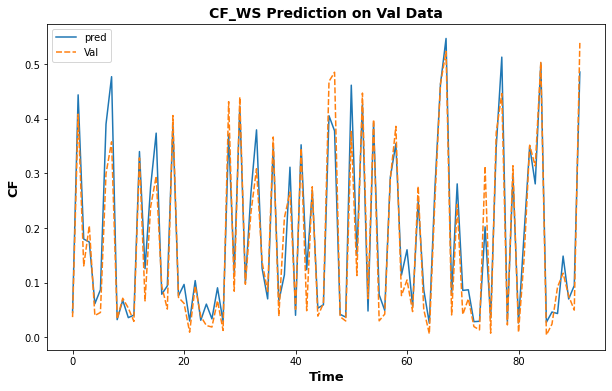

In [36]:
from sklearn import datasets, ensemble

from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


## gradientBoostingRegressor

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

mlr = ensemble.GradientBoostingRegressor(**params)
## engineer new features to improve the results

sc_x = StandardScaler()

# scale and normalize training data
X_new = sc_x.fit_transform(x)

# model fitting
mlr.fit(X_new, y)

# prediction
X_val_new = sc_x.transform(x_val)
y_hat = mlr.predict(X_val_new)
y_hat = y_hat.reshape(y_hat.shape[0],-1)
print(f'Training accu: {mlr.score(X_new, y)}')
print(f'Test accu: {mlr.score(X_val_new, y_val)}')
mae = mean_absolute_error(y_val, y_hat)

#visualize predication 
results = np.concatenate((y_hat, y_val), axis=1)
df_res = pd.DataFrame(results, columns=["pred", "Val"])           
## Set figure size
fig, ax = plt.subplots(figsize = (10,6))
# Plot the curve
sns.lineplot(data=df_res)
ax.set_title('CF_WS Prediction on Val Data', fontdict={'fontsize':14, 'fontweight':'bold'})
# Set label for x-axis
ax.set_xlabel( "Time" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})
# Set label for y-axis
ax.set_ylabel( "CF" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})

# output MAE
print(f'validation data MAE: {np.mean(abs(y_hat - y_val)):.3f}')
print(f'validation data MAE from sklearn mae metrics: {mae:.3f}')


# steps = [
#     ('scalar', StandardScaler()),
#     ('poly', PolynomialFeatures(degree=2)),
#     ('model', ensemble.GradientBoostingRegressor(**params))
# ]

# xgboost_pipeline = Pipeline(steps)
# y = y.reshape(y.shape[0])
# xgboost_pipeline.fit(x, y)
# print(f'Training accu: {xgboost_pipeline.score(x, y)}')
# print(f'Test accu: {xgboost_pipeline.score(x_val, y_val)}')

# # prediction

# y_hat = xgboost_pipeline.predict(x_val)
# mae = mean_absolute_error(y_val, y_hat)

# #visualize predication 
# fig, ax = plt.subplots()
# y_hat = y_hat.reshape(y_hat.shape[0],-1)
# print(y_hat.shape)
# print(y_val.shape)
# results = np.concatenate((y_hat, y_val), axis=1)
# df_res = pd.DataFrame(results, columns=["pred", "groundtruth"])           
# sns.lineplot(data=df_res)

# # output MAE
# print(f'validation data MAE from sklearn mae metrics: {np.mean(abs(y_hat - y_val)):.3f}')
# print(f'validation data MAE: {mae:.3f}')

#### XGBoost Regressor provides the best results on validation data with MAE 0.026

[21:42:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
Training accu: 0.9991601599447165
Test accu: 0.9561929373442302
validation data MAE: 0.025
validation data MAE from sklearn mae metrics: 0.025


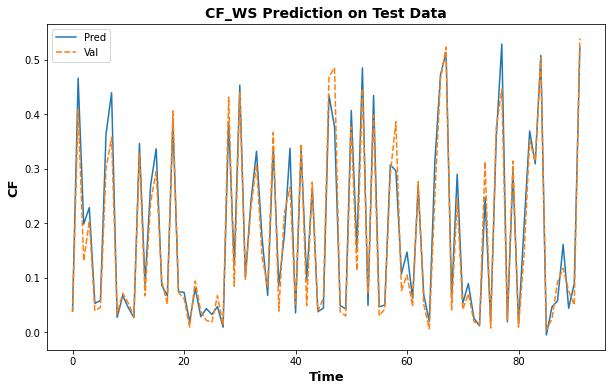

In [37]:
import xgboost as xgb

from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


## XGBoostRegressor
xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)

## engineer new features to improve the results

sc_x = StandardScaler()

# scale and normalize training data
X_new = sc_x.fit_transform(x)

# model fitting
xgb_model.fit(X_new, y)

# prediction
X_val_new = sc_x.transform(x_val)
y_hat = xgb_model.predict(X_val_new)
y_hat = y_hat.reshape(y_hat.shape[0],-1)
print(f'Training accu: {xgb_model.score(X_new, y)}')
print(f'Test accu: {xgb_model.score(X_val_new, y_val)}')
mae = mean_absolute_error(y_val, y_hat)

#visualize predication 
results = np.concatenate((y_hat, y_val), axis=1)
df_res = pd.DataFrame(results, columns=["Pred", "Val"])           
## Set figure size
fig, ax = plt.subplots(figsize = (10,6))
# Plot the curve
sns.lineplot(data=df_res)
ax.set_title('CF_WS Prediction on Test Data', fontdict={'fontsize':14, 'fontweight':'bold'})
# Set label for x-axis
ax.set_xlabel( "Time" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})
# Set label for y-axis
ax.set_ylabel( "CF" , fontdict= { 'fontsize': 13, 'fontweight':'bold'})

# output MAE
print(f'validation data MAE: {np.mean(abs(y_hat - y_val)):.3f}')
print(f'validation data MAE from sklearn mae metrics: {mae:.3f}')

# steps = [
#     ('scalar', StandardScaler()),
#     ('poly', PolynomialFeatures(degree=2)),
#     ('model',xgb.XGBRegressor(objective="reg:linear", random_state=42))
# ]

# rf_pipeline = Pipeline(steps)
# y = y.reshape(y.shape[0])
# rf_pipeline.fit(x, y)
# print(f'Train : {rf_pipeline.score(x, y)}')
# print(f'Val: {rf_pipeline.score(x_val, y_val)}')

# # prediction

# y_hat = rf_pipeline.predict(x_val)
# mae = mean_absolute_error(y_val, y_hat)

# #visualize predication 
# fig, ax = plt.subplots()
# y_hat = y_hat.reshape(y_hat.shape[0],-1)
# print(y_hat.shape)
# print(y_val.shape)
# results = np.concatenate((y_hat, y_val), axis=1)
# df_res = pd.DataFrame(results, columns=["pred", "groundtruth"])           
# sns.lineplot(data=df_res)

# # output MAE
# print(f'validation data MAE from sklearn mae metrics: {np.mean(abs(y_hat - y_val)):.3f}')
# print(f'validation data MAE: {mae:.3f}')

## Test 

### Process Test Data

In [38]:
# extract hour, day, month feature
df_test['hour'] = df_test['DATETIME'].dt.hour
df_test['month'] = df_test['DATETIME'].dt.month
df_test['day'] = df_test['DATETIME'].dt.day


# X = df_train.set_index('DATETIME')
x_test = df_test.drop(['DATETIME','CF'], axis=1)
x_test = x_test.values

### Train a Model with all the data and Run Test and compare with the Model trained by partial data(x_train)

[21:42:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


Text(0, 0.5, 'CF')

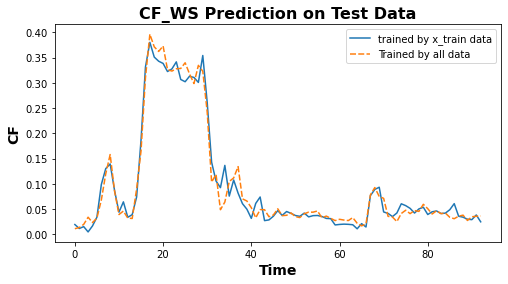

In [39]:
import xgboost as xgb

from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## All data samples
# split dataset
Y = df_train[['CF']]
X = df_train.drop(['DATETIME','CF'], axis=1)
x_all, y_all = X.values, Y.values

## XGBoostRegressor
xgb_model_all = xgb.XGBRegressor(objective="reg:linear", random_state=42)

## engineer new features to improve the results

sc_x_all = StandardScaler()

# scale and normalize training data
X_new_all = sc_x_all.fit_transform(x_all)

# model fitting
xgb_model_all.fit(X_new_all, y_all)

# prediction
X_val_new_all = sc_x_all.transform(x_test)
y_hat_all = xgb_model_all.predict(X_val_new_all)
y_hat_test_all = y_hat_all.reshape(y_hat_all.shape[0],-1)

# prediction
X_test_new = sc_x.transform(x_test)
y_hat_test = xgb_model.predict(X_test_new)
y_hat_test = y_hat_test.reshape(y_hat_test.shape[0],-1)

#visualize predication 
## Prepare dataframe
results = np.concatenate((y_hat_test, y_hat_test_all), axis=1)
df_res = pd.DataFrame(results, columns=["trained by x_train data", "Trained by all data"]) 
## Set figure size
fig, ax = plt.subplots(figsize = (8,4))
## Plot the curve
sns.lineplot(data=df_res)
ax.set_title('CF_WS Prediction on Test Data', fontdict={'fontsize':16, 'fontweight':'bold'})
## Set label for x-axis
ax.set_xlabel( "Time" , fontdict= { 'fontsize': 14, 'fontweight':'bold'})
## Set label for y-axis
ax.set_ylabel( "CF" , fontdict= { 'fontsize': 14, 'fontweight':'bold'})
# print(f'final prediction:{y_hat_test_all}')